<a href="https://colab.research.google.com/github/Rangan17/Chest_X_ray_classification/blob/main/Pneumonia_Classifier_with_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

[Data Scorce](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np

def show_image(image,label,get_denormalize = True):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)

    else:
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    image = image*std + mean
    image = np.clip(image,0,1)

    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):

    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])


    image = image*std + mean
    img = np.clip(image,0,1)

    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()
    return None

In [ ]:
class CFG:

  epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  train_path='/content/drive/MyDrive/dataset/Train.csv'
  validate_path='/content/drive/MyDrive/dataset/val.csv'
  test_path='/content/drive/MyDrive/dataset/Test_Set '

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [ ]:
from torchvision import transforms as T,datasets

In [ ]:
train_transform = T.Compose([

                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([

                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([

                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  60


In [ ]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  16


In [ ]:
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  60


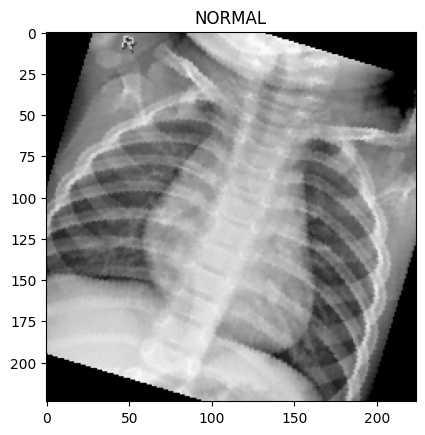

In [ ]:
img,label = trainset[12]
#print(trainset.class_to_idx)

class_name =["NORMAL","PNEUMONIA"]
show_image(img,class_name[label])

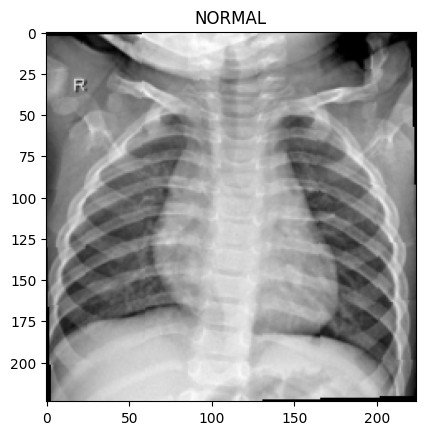

In [ ]:
img,label = trainset[12]
#print(trainset.class_to_idx)

class_name =["NORMAL","PNEUMONIA"]
show_image(img,class_name[label])

# randomly rotated

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader)
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:4
No. of Total examples:60


In [ ]:
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader)
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:1
No. of Total examples:16


In [ ]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader)
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:4
No. of Total examples:60


In [ ]:
!pip install timm # install PyTorch Image Models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.5 MB/s eta 0:00:00


In [ ]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


In [ ]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [ ]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2),
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [ ]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

In [ ]:
class PneumoniaTrainer():

    def __init__(self,criterion = None,optimizer = None,schedular = None):

        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular

    def train_batch_loop(self,model,trainloader):

        train_loss = 0.0
        train_acc = 0.0

        for images,labels in tqdm(trainloader):

            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits,labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits,labels)

        return train_loss / len(trainloader), train_acc / len(trainloader)


    def valid_batch_loop(self,model,validloader):

        valid_loss = 0.0
        valid_acc = 0.0

        for images,labels in tqdm(validloader):

            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits,labels)

            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)

        return valid_loss / len(validloader), valid_acc / len(validloader)


    def fit(self,model,trainloader,validloader,epochs):

        valid_min_loss = np.Inf

        for i in range(epochs):

            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###

            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###

            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss


            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.6828025579452515
Epoch : 1 Train Loss : 0.670717 Train Acc : 0.604167
Epoch : 1 Valid Loss : 0.682803 Valid Acc : 0.500000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.6828025579452515 --> 0.6329099535942078
Epoch : 2 Train Loss : 0.536698 Train Acc : 0.875000
Epoch : 2 Valid Loss : 0.632910 Valid Acc : 0.625000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.6329099535942078 --> 0.6310197114944458
Epoch : 3 Train Loss : 0.420007 Train Acc : 0.812500
Epoch : 3 Valid Loss : 0.631020 Valid Acc : 0.625000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.6310197114944458 --> 0.5721030235290527
Epoch : 4 Train Loss : 0.347593 Train Acc : 0.859375
Epoch : 4 Valid Loss : 0.572103 Valid Acc : 0.750000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.305747 Train Acc : 0.880208
Epoch : 5 Valid Loss : 0.579571 Valid Acc : 0.687500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.155361 Train Acc : 0.953125
Epoch : 6 Valid Loss : 0.607876 Valid Acc : 0.687500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.157923 Train Acc : 0.953125
Epoch : 7 Valid Loss : 0.608337 Valid Acc : 0.687500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.5721030235290527 --> 0.5093218088150024
Epoch : 8 Train Loss : 0.228758 Train Acc : 0.916667
Epoch : 8 Valid Loss : 0.509322 Valid Acc : 0.687500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.5093218088150024 --> 0.4043477177619934
Epoch : 9 Train Loss : 0.116515 Train Acc : 0.942708
Epoch : 9 Valid Loss : 0.404348 Valid Acc : 0.687500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.4043477177619934 --> 0.22107526659965515
Epoch : 10 Train Loss : 0.104117 Train Acc : 0.963542
Epoch : 10 Valid Loss : 0.221075 Valid Acc : 0.937500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.22107526659965515 --> 0.21354557573795319
Epoch : 11 Train Loss : 0.064976 Train Acc : 0.968750
Epoch : 11 Valid Loss : 0.213546 Valid Acc : 0.937500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.189701 Train Acc : 0.911458
Epoch : 12 Valid Loss : 0.236688 Valid Acc : 0.937500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.054763 Train Acc : 0.984375
Epoch : 13 Valid Loss : 0.565318 Valid Acc : 0.625000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.102871 Train Acc : 0.958333
Epoch : 14 Valid Loss : 0.395030 Valid Acc : 0.750000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.21354557573795319 --> 0.20407691597938538
Epoch : 15 Train Loss : 0.107058 Train Acc : 0.953125
Epoch : 15 Valid Loss : 0.204077 Valid Acc : 0.937500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.191061 Train Acc : 0.901042
Epoch : 16 Valid Loss : 0.274486 Valid Acc : 0.937500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.125146 Train Acc : 0.942708
Epoch : 17 Valid Loss : 0.498834 Valid Acc : 0.750000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.044468 Train Acc : 0.968750
Epoch : 18 Valid Loss : 0.626521 Valid Acc : 0.687500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.133442 Train Acc : 0.953125
Epoch : 19 Valid Loss : 0.871842 Valid Acc : 0.625000


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.348181 Train Acc : 0.812500
Epoch : 20 Valid Loss : 0.903652 Valid Acc : 0.687500


In [ ]:
model.load_state_dict(torch.load('/content/ColabPneumoniaModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/4 [00:00<?, ?it/s]

Test Loss : 0.44244256615638733
Test Acc : 0.8541666865348816


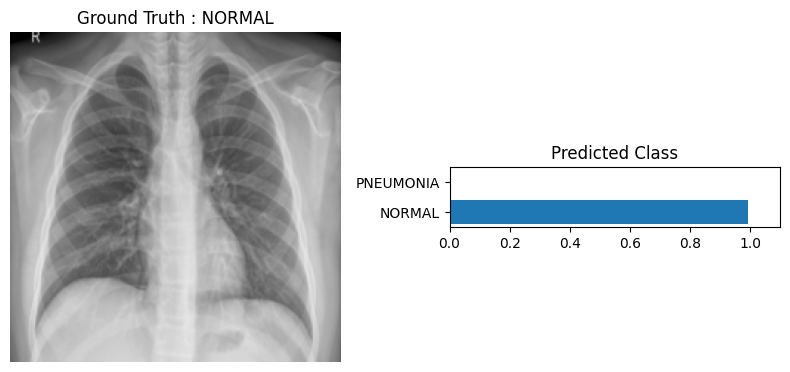

In [ ]:
import torch.nn.functional as F

image,label = testset[15]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

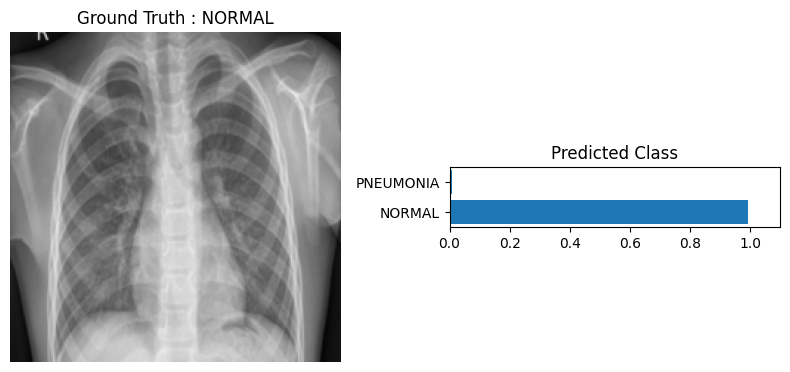

In [ ]:
import torch.nn.functional as F

image,label = testset[11]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

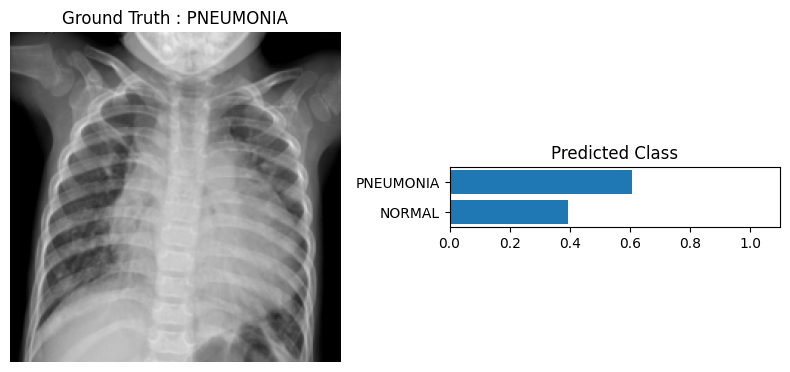

In [ ]:
import torch.nn.functional as F

image,label = testset[50]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

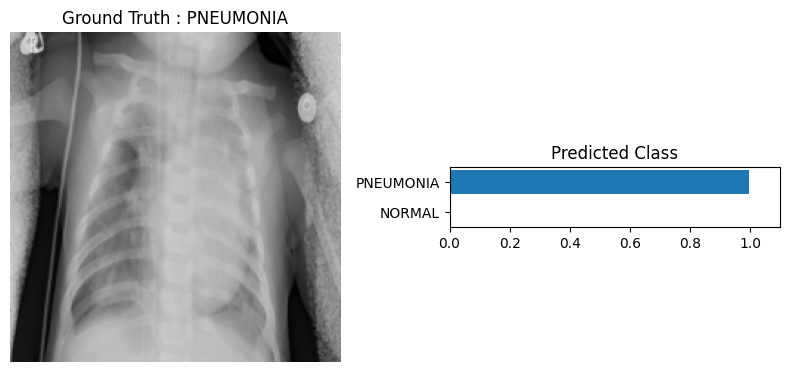

In [ ]:
import torch.nn.functional as F

image,label = testset[32]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)